In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
/kaggle/input/facebook-recruiting-iii-keyword-extraction/SampleSubmission.csv
/kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip


### Problem Statemtent

Suggest the tags based on the content that was there in the question posted on Stackoverflow.

**Source**: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/

#### Data Overview
Refer source - https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/

All of the data is in 2 files: Train and Test.

Train.csv contains 4 columns: Id,Title,Body,Tags.

Test.csv contains the same columns but without the Tags, which you are to predict.

Size of Train.csv - 6.75GB

Size of Test.csv - 2GB

Number of rows in Train.csv = 6034195

The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).

### Data Field Explaination

Dataset contains 6,034,195 rows. The columns in the table are:

Id - Unique identifier for each question

Title - The question's title

Body - The body of the question

Tags - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')

In [2]:
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import csv
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    #link = 'https://drive.google.com/file/d/1fu-vaduSu2lEXSygdHVp3ViknfgCmxYV/view?usp=sharing'
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('../input/facebook-recruiting-iii-keyword-extraction/Train.zip', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

180000 rows
360000 rows
540000 rows
720000 rows
900000 rows
1080000 rows
1260000 rows
1440000 rows
1620000 rows
1800000 rows
1980000 rows
2160000 rows
2340000 rows
2520000 rows
2700000 rows
2880000 rows
3060000 rows
3240000 rows
3420000 rows
3600000 rows
3780000 rows
3960000 rows
4140000 rows
4320000 rows
4500000 rows
4680000 rows
4860000 rows
5040000 rows
5220000 rows
5400000 rows
5580000 rows
5760000 rows
5940000 rows
6120000 rows
Time taken to run this cell : 0:04:00.759978


In [4]:
# checking for total no.of rows
if os.path.isfile('train.db'):
    start = datetime.now()
    conn = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT COUNT(*) FROM DATA""",conn)
    print("Number of rows in db: ",num_rows['COUNT(*)'].values[0])
    conn.close() # closing db connection
    print("Time taken :",datetime.now() - start)
else:
    print('train.db file not found')

Number of rows in db:  6034196
Time taken : 0:00:03.325281


In [5]:
#checking for duplicates
if os.path.isfile('train.db'):
    start = datetime.now()
    conn = sqlite3.connect('train.db')
    df_dup = pd.read_sql_query('SELECT Title,Body,Tags,COUNT(*) as dup FROM DATA GROUP BY Title,Body,Tags',conn)
    conn.close()
    print("Time taken: ",datetime.now() - start)
    print('duplicate questions: ',num_rows['COUNT(*)'].values[0]-df_dup.shape[0])
    
else:
    print("train.db not found!!")

Time taken:  0:00:59.457289
duplicate questions:  1827881


In [6]:
# occurence
df_dup.dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: dup, dtype: int64

In [7]:
df_dup.head()

,Title,Body,Tags,dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [8]:
df_dup.info(show_counts = True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206315 entries, 0 to 4206314
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Title   4206315 non-null  object
 1   Body    4206315 non-null  object
 2   Tags    4206308 non-null  object
 3   dup     4206315 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 128.4+ MB


In [9]:
df_dup["tag_count"] = df_dup["Tags"].apply(
    lambda text: len(text.split(" ")) if text != None else 0 
)
df_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568291
5     505158
0          7
Name: tag_count, dtype: int64

In [10]:
df_dup.head()

,Title,Body,Tags,dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [11]:
# creating new db, removing duplicates
if  not os.path.isfile('../input/d/elemento/facebook-recruiting-iii-keyword-extraction/train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train', disk_dup)

In [12]:
if  os.path.isfile('/kaggle/working/train_no_dup.db'):
    start = datetime.now()
    conn = sqlite3.connect('train_no_dup.db')
    tag_df = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", conn)
    conn.close()
    # dropping unwanted column
    tag_df.drop(tag_df.index[0], inplace = True) # drops the first row
    #tag_df.head()
    print("Time taken: ",datetime.now() - start)
    
    
else:
    print("train_no_dup.db not found!!")
    

Time taken:  0:00:03.619716


In [13]:
tag_df.head()

,Tags
1,c# silverlight data-binding
2,c# silverlight data-binding columns
3,jsp jstl
4,java jdbc
5,facebook api facebook-php-sdk


In [14]:
'''
# Connect to the database file
conn = sqlite3.connect('train_no_dup.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Execute a query to retrieve data from a table
cursor.execute('SELECT * FROM no_dup_train')

# Fetch all rows from the result set
rows = cursor.fetchall()

# Print the data
for row in rows:
    print(row)

# Close the database connection
conn.close() '''


"\n# Connect to the database file\nconn = sqlite3.connect('train_no_dup.db')\n\n# Create a cursor object to execute SQL queries\ncursor = conn.cursor()\n\n# Execute a query to retrieve data from a table\ncursor.execute('SELECT * FROM no_dup_train')\n\n# Fetch all rows from the result set\nrows = cursor.fetchall()\n\n# Print the data\nfor row in rows:\n    print(row)\n\n# Close the database connection\nconn.close() "

### Analysis of tags

In [15]:
no_dup["tag_count"] = df_dup["Tags"].apply(
    lambda text: len(text.split(" ")) if text != None else 0 
)
df_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568291
5     505158
0          7
Name: tag_count, dtype: int64

In [16]:
tag_df = tag_df.dropna(subset=['Tags'])  # dropping rows with missing value in tags column

# Importing & Initializing the "CountVectorizer" object, which is scikit-learn's bag of words tool.
# By default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())

# fit_transform() does two functions
# First, it fits the model & learns the vocabulary
# Second, it transforms our training data into feature vectors. 
# The input to fit_transform should be a list of strings.
tag_vec = vectorizer.fit_transform(tag_df['Tags'])

In [17]:
print("Number of data points :", tag_vec.shape[0])
print("Number of unique tags :", tag_vec.shape[1])

Number of data points : 4206307
Number of unique tags : 42048


In [18]:
#get feature names
tags = vectorizer.get_feature_names_out()
print(tags[:10])

['.a' '.app' '.asp.net-mvc' '.aspxauth' '.bash-profile' '.class-file'
 '.cs-file' '.doc' '.drv' '.ds-store']


In [19]:
# accessing sparse matrix (tag_vec) elements. storing the document term matrix in a dictionary.
freqs = tag_vec.sum(axis = 0).A1 
# calculates the sum of all elements along the vertical axis (axis=0) of the sparse matrix.
# .A1 is used to convert the resulting sum matrix to a 1-D NumPy array.
result = dict(zip(tags, freqs))
#zip(tags, freqs) creates an iterator that pairs each tag with its corresponding frequency value from the freqs array.

In [20]:
# Saving this dictionary to csv files.
if not os.path.isfile('../input/d/elemento/facebook-recruiting-iii-keyword-extraction/tag_counts_dict_vec.csv'):
    with open('tag_counts_dict_vec.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tags_df = pd.read_csv("/kaggle/working/tag_counts_dict_vec.csv", names=['Tags', 'Counts'])
tags_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [21]:
# sorting
tags_df_sorted = tags_df.sort_values(['Counts'], ascending=False)
tags_counts = tags_df_sorted['Counts'].values

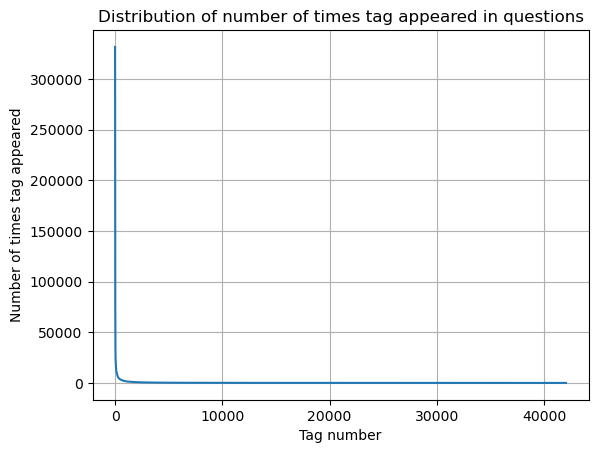

In [22]:
plt.plot(tags_counts)
plt.title("Distribution of number of times tag appeared in questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

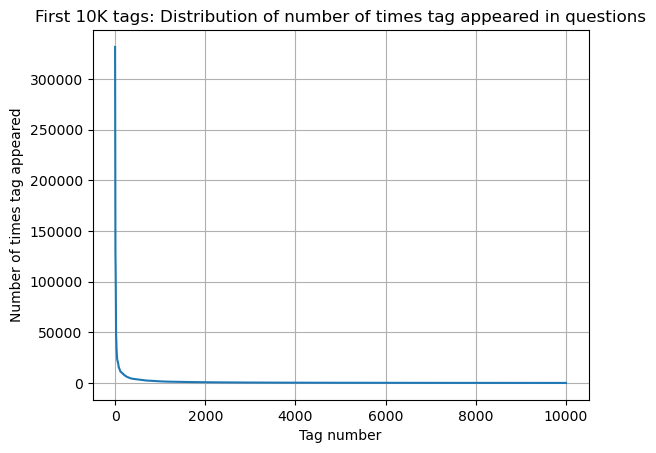

In [23]:
#checking for first 10K tags
plt.plot(tags_counts[0:10000])
plt.title("First 10K tags: Distribution of number of times tag appeared in questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()


In [24]:
print(len(tags_counts[0:10000:25]), tags_counts[0:10000:25])

400 [331505  44829  22429  17728  13364  11162  10029   9148   8054   7151
   6466   5865   5370   4983   4526   4281   4144   3929   3750   3593
   3453   3299   3123   2986   2891   2738   2647   2527   2431   2331
   2259   2186   2097   2020   1959   1900   1828   1770   1723   1673
   1631   1574   1532   1479   1448   1406   1365   1328   1300   1266
   1245   1222   1197   1181   1158   1139   1121   1101   1076   1056
   1038   1023   1006    983    966    952    938    926    911    891
    882    869    856    841    830    816    804    789    779    770
    752    743    733    725    712    702    688    678    671    658
    650    643    634    627    616    607    598    589    583    577
    568    559    552    545    540    533    526    518    512    506
    500    495    490    485    480    477    469    465    457    450
    447    442    437    432    426    422    418    413    408    403
    398    393    388    385    381    378    374    370    367    365
  

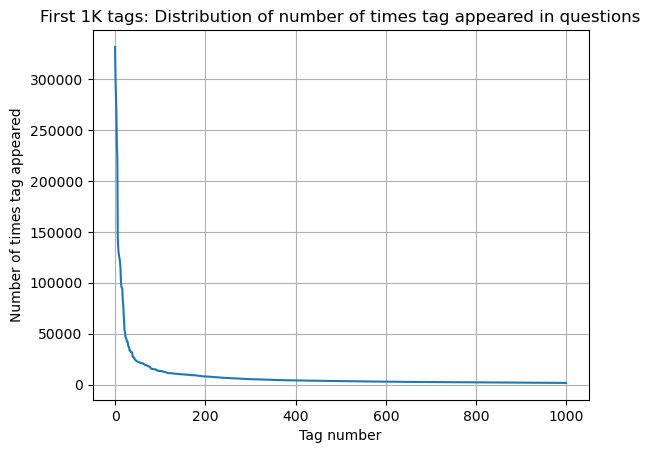

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2986   2983   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   2556   2527   2510   2482   2460   2444
  

In [25]:
# checking for frist 1K tags
plt.plot(tags_counts[0:1000])
plt.title("First 1K tags: Distribution of number of times tag appeared in questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
#print(len(tags_counts[0:1000:10]), tags_counts[0:1000:10])
print(len(tags_counts[0:1000:5]), tags_counts[0:1000:5])

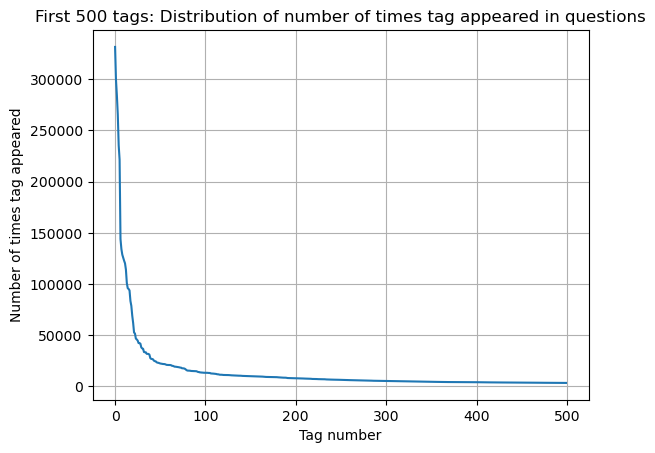

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [26]:
# checking for frist 500 tags
plt.plot(tags_counts[0:500])
plt.title("First 500 tags: Distribution of number of times tag appeared in questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tags_counts[0:500:5]), tags_counts[0:500:5])

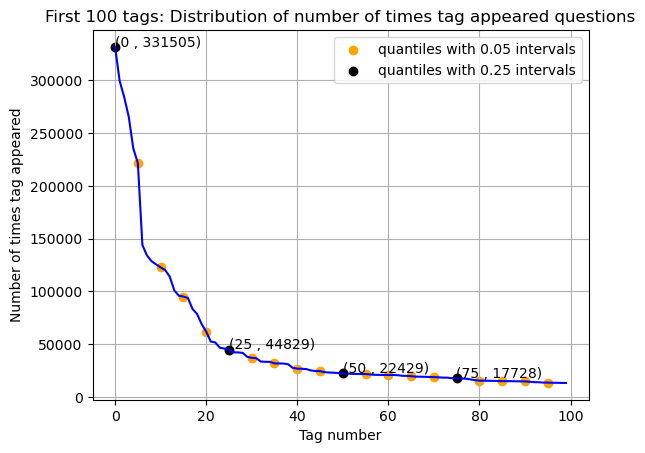

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [27]:
# plotting for first 100 tags
plt.plot(tags_counts[0:100],c = 'b')
plt.scatter(x= list(range(0,100,5)), y = tags_counts[0:100:5],c = 'orange', label = "quantiles with 0.05 intervals")
plt.scatter(x= list(range(0,100,25)), y = tags_counts[0:100:25],c = 'black', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tags_counts[0:100:25]):
    plt.annotate(text="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('First 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tags_counts[0:100:5]), tags_counts[0:100:5])

In [28]:
#storng tags greater than 10K in one list
lst_tags_gt10K = tags_df[tags_df.Counts>10000].Tags
print("{} tags used more than 10K times".format(len(lst_tags_gt10K)))

# storing tags greater than 100K times in a list
lst_tags_gt100K = tags_df[tags_df.Counts>100000].Tags
print("{} tags used more than 10K times".format(len(lst_tags_gt100K)))

153 tags used more than 10K times
14 tags used more than 10K times


**Observations:**

* 153 tags are used more than 10000 times
* 14 tags are used more than 100000 times
* Most frequent tag occured 331505 times

#### Most Frequent tags

In [29]:
# the list of count of tags in each question
tag_que_count = tag_vec.sum(axis = 1).tolist()
# this will return list of lists, converting the list of lists to single list
tag_que_count = [int(j) for i in tag_que_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_que_count)))

print(tag_que_count[:5])


We have total 4206307 datapoints.
[3, 4, 2, 2, 3]


In [30]:
#checking max, min, avg tags used 
print("Maximum number of tags per question : %d"%max(tag_que_count))
print("Minimum number of tags per question : %d"%min(tag_que_count))
print("Average number of tags per question : %f"%((sum(tag_que_count)*1.0)/len(tag_que_count)))

Maximum number of tags per question : 5
Minimum number of tags per question : 1
Average number of tags per question : 2.899443


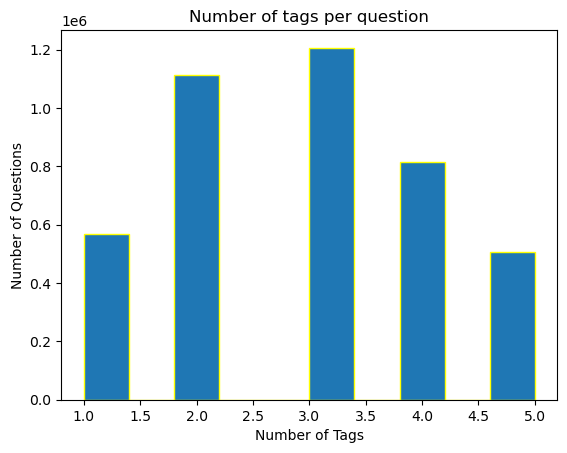

In [31]:

plt.hist(tag_que_count, edgecolor = 'yellow')
plt.title("Number of tags per question")
plt.xlabel("Number of Tags")
plt.ylabel("Number of Questions")
plt.show()

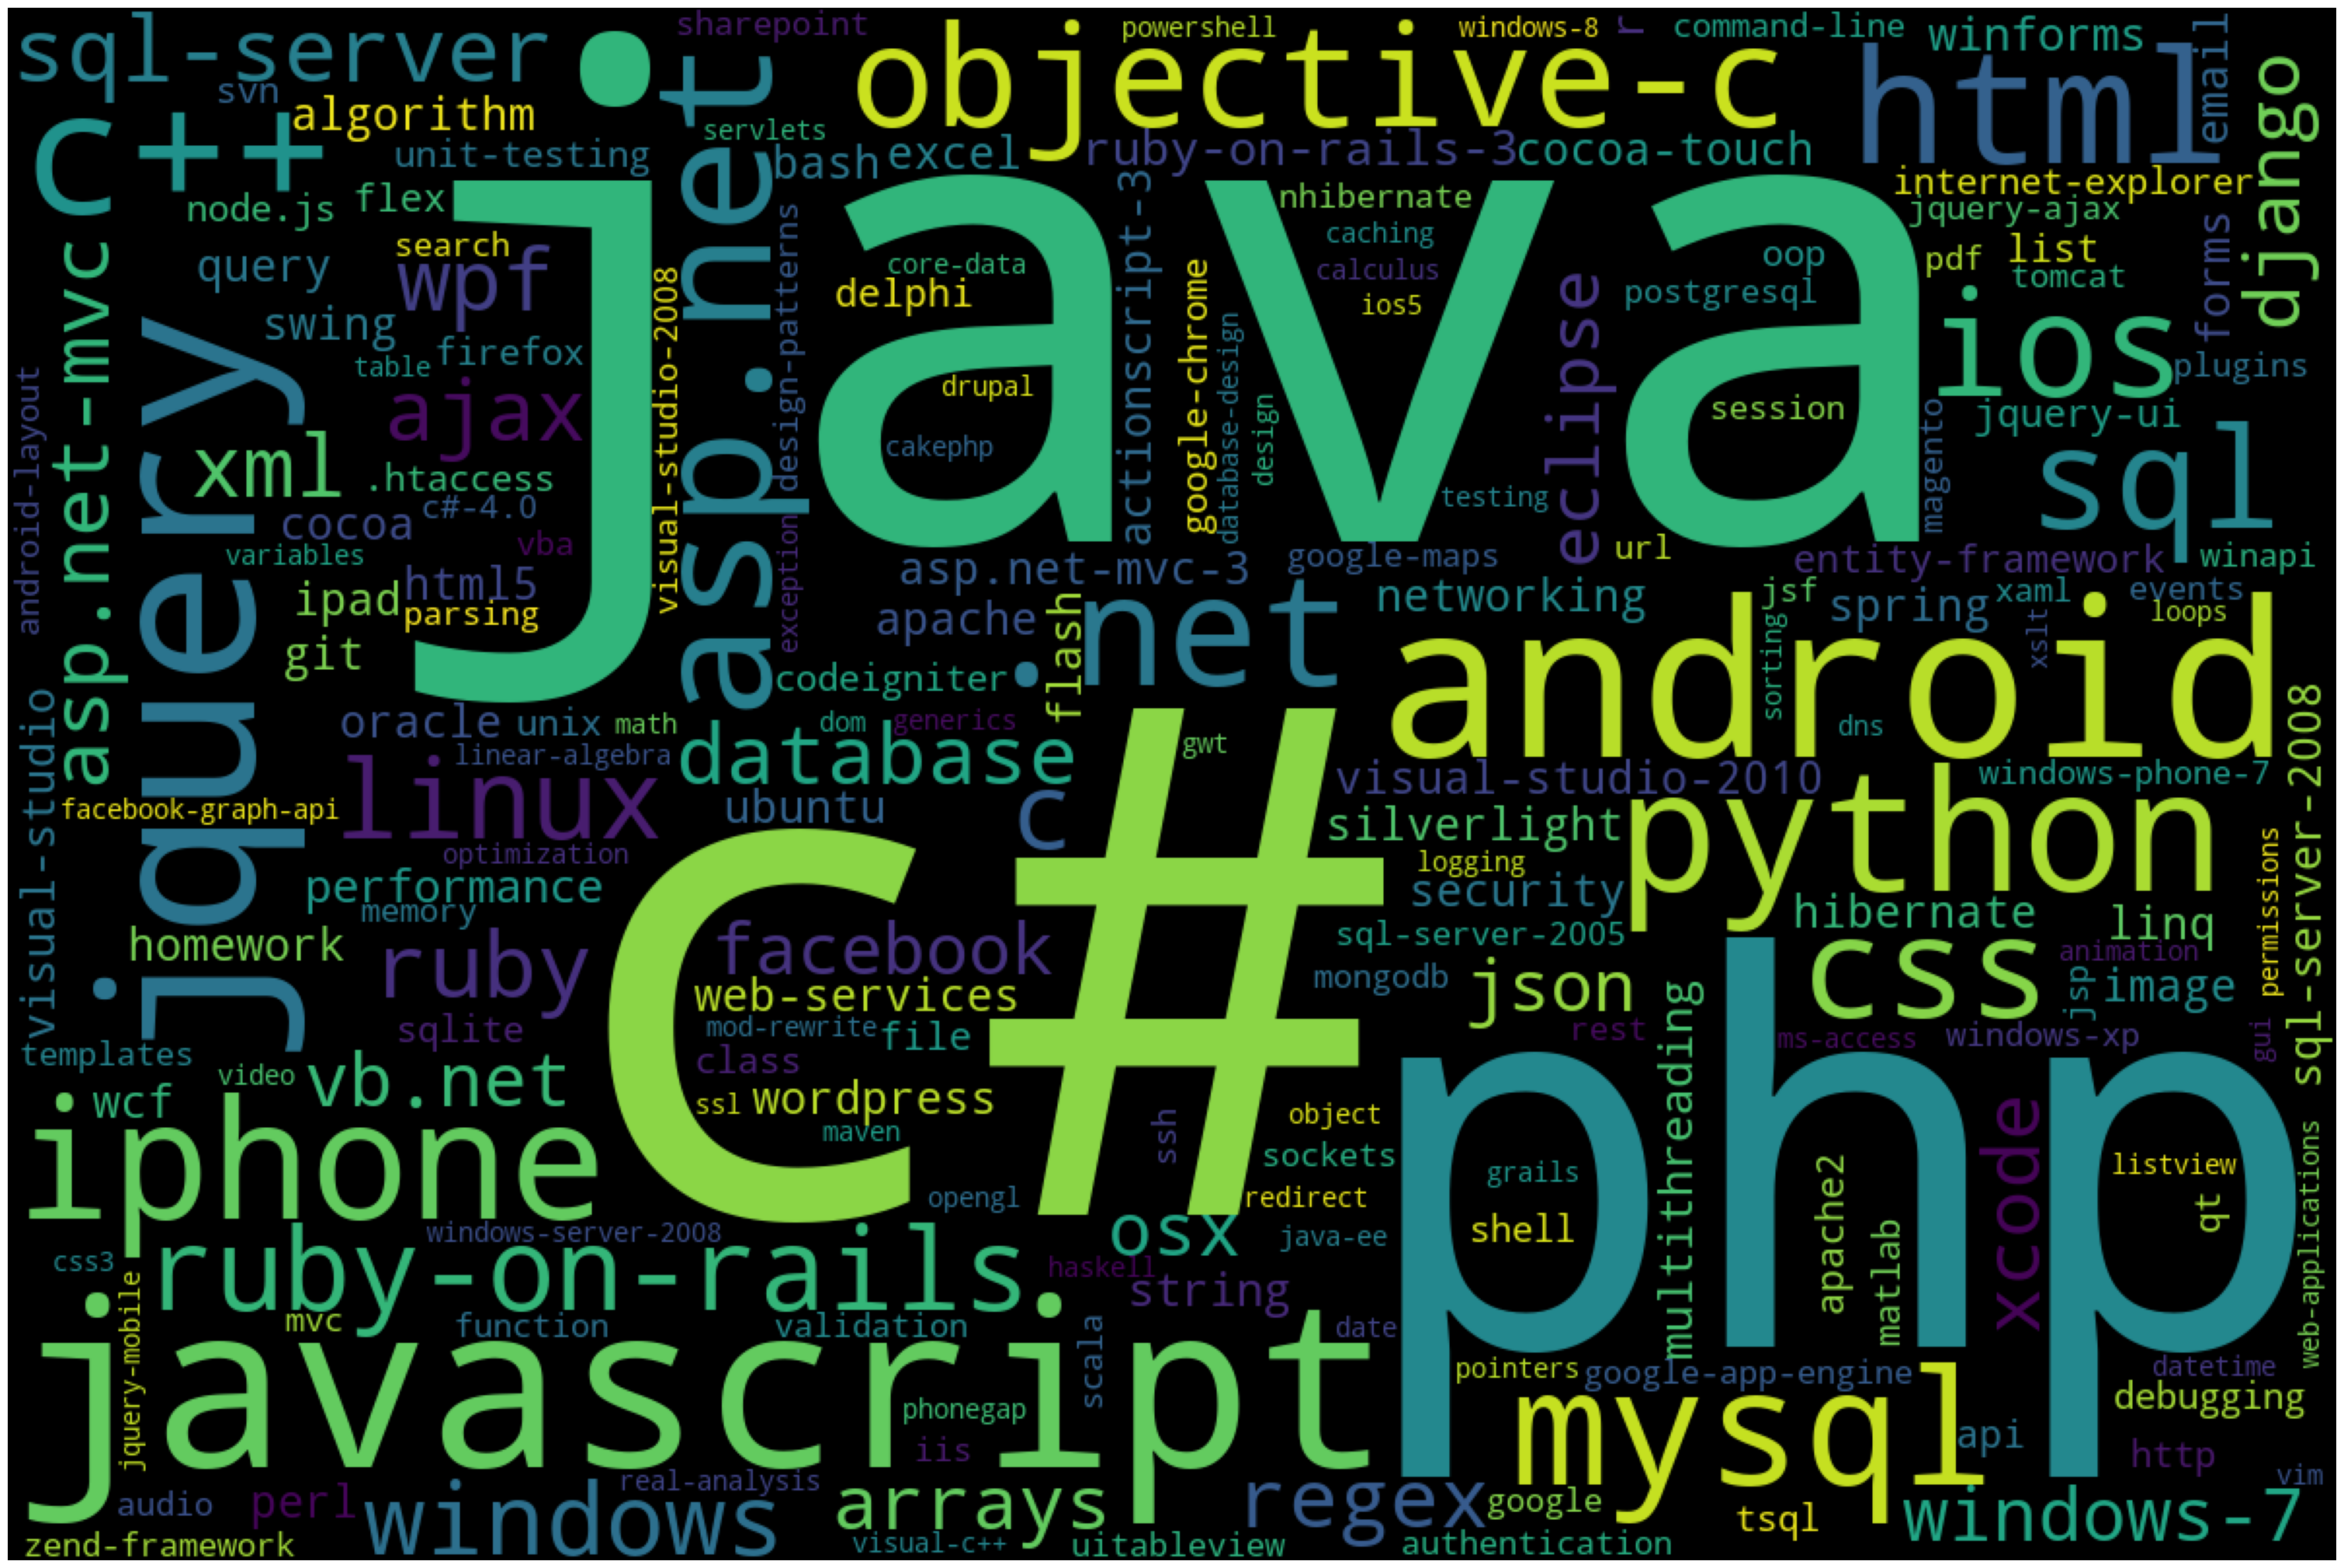

Time taken 0:00:03.901859


In [32]:
# most frequent tag
from wordcloud import WordCloud
start = datetime.now()
tup = dict(result.items()) # converting the 'result' dictionary to 'list of tuples'
wordcloud = WordCloud(background_color = 'black',width = 1200, height = 800).generate_from_frequencies(tup)
fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken", datetime.now()  - start)

**Observations:**

* Maximum number of tags per question : 5
* Minimum number of tags per question : 1
* Average number of tags per question : 2.899443
* Most of the question have 2 to 3 tags
* Mostly tags are of programming language - c#,java,php,javascript,jquery etc..


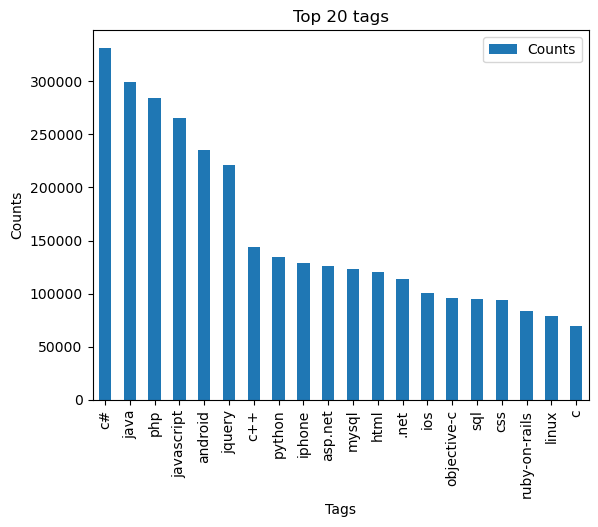

In [33]:
# checking top 20 tags
i = np.arange(20)
tags_df_sorted.head(20).plot(kind = 'bar')
plt.title("Top 20 tags")
plt.xticks(i,tags_df_sorted.head(20)['Tags'])
plt.xlabel("Tags")
plt.ylabel("Counts")
plt.show()

**Observations:**
* c# is the most frequently used tag
* android, ios, linux are most frequent tags for OS

#### Cleaning & preprocessing of data

**Preprocessing**

1. Sampling 1M data points [as running all the datapoints at a time will consume more time and also machines with lower storage will find it difficult to run smoothly]
2. Seperating code snippets from body 
3. Removing special character from question title and description only [Not from code]
4. Removing HTML tags & Stopwords except 'C'
5. Convert all character to lowercase
6. Using SnowballStemmer to stem the words

In [34]:
def striphtml(data):
    cleanr = re.compile('<.*?>') #matches any HTML tag in the text
    cleantext = re.sub(cleanr, '', str(data)) #re.sub substitute all occurrences of the HTML tags matched by the 'cleanr'
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english") # reduces words to their base or root form => allows different variation of same word to treated as same
    

In [35]:
# https://www.geeksforgeeks.org/python-sqlite-create-table/
def create_connection(db_file):
    try:
        # creating a db connection to the SQLite db specified by db_file
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return None

# creating table
def create_table(conn,create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)  # create_table_sql: a CREATE TABLE statement
    except Error as e:
        print(e)

def checkTableExists(dbcon):
    cur = dbcon.cursor()
    str = "SELECT name from sqlite_master where type = 'table'"
    table_names = cur.execute(str)
    print("Tables in database: ") # will show no value for now
    tables = table_names.fetchall()
    print(tables[0][0])
    return (len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)
        

Tables in database: 
QuestionsProcessed


In [36]:
# creating new db to store sample and preprocessed questions
start = datetime.now()
read_db = '/kaggle/working/train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        reader.execute('SELECT Title, Body, Tags FROM no_dup_train ORDER BY RANDOM() LIMIT 1000000;')

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer = conn_w.cursor()
        if tables != 0:
            writer.execute('DELETE FROM QuestionsProcessed WHERE 1')
            print('cleared')
            
print("Time taken: ",datetime.now() - start)

Tables in database: 
QuestionsProcessed
cleared
Time taken:  0:01:24.656193


In [37]:
# https://pynative.com/python-sqlite-select-from-table/
#import re
start = datetime.now()
preprocessed_data_list = []
reader.fetchone() # skips the first row in reader object
questions_with_code=0
len_pre=0
len_post=0
questions_processed = 0
for row in reader:
    is_code = 0
    title, question, tags = row[0], row[1], row[2]

    # checking <code in que>, if yes, counter quewithcode increments to 1 and is_code flag is set to 1
    if '<code>' in question:
        questions_with_code += 1
        is_code = 1
    x = len(question) + len(title)
    len_pre += x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    question = re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL) #removing code
    question = striphtml(question.encode('utf-8')) # remove any HTML tags
    title = title.encode('utf-8')

    question = str(title) + " " + str(question)
    question = re.sub(r'[^A-Za-z]+',' ',question) # removing non-alphabetic character with space
    words = word_tokenize(str(question.lower()))

    # Removing all single letter and stopwords from question except for the letter 'c'
    question=' '.join(
        str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j) != 1 or j == 'c')
    )

    len_post += len(question)
    tup = (question, code, tags, x, len(question), is_code)
    questions_processed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup) # values to be inserted are specified using placeholders represented by question marks
    if (questions_processed % 100000 == 0):
        print("Number of questions completed = ",questions_processed)

no_dup_avg_len_pre = (len_pre*1.0) / questions_processed
no_dup_avg_len_post = (len_post*1.0) / questions_processed

print("Avg length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print("Avg length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_processed))
print("Time taken to run this cell :", datetime.now() - start)


Number of questions completed =  100000
Number of questions completed =  200000
Number of questions completed =  300000
Number of questions completed =  400000
Number of questions completed =  500000
Number of questions completed =  600000
Number of questions completed =  700000
Number of questions completed =  800000
Number of questions completed =  900000
Avg length of questions(Title+Body) before processing: 1171
Avg length of questions(Title+Body) after processing: 337
Percent of questions containing code: 57
Time taken to run this cell : 0:22:35.302900


In [38]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [39]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('obtain thread status mvc control anoth creat mobil websit use separ modul individu view control nin one modul call servic generat pdf report process take approx min show status indic remov indic get respons work well hang ui user navig oper nthe problem come user navig anoth modul know get status thread run state move anoth control thread lost move view control nis way achiev',)
----------------------------------------------------------------------------------------------------
('replac content entir column mysql content two column got three column tabl login name familynam ni want replac everyth column login content name familynam nexampl nlogin janvdv nname jan nfamilynam vandevoord ni want login jan vandevoord nis way',)
----------------------------------------------------------------------------------------------------
('get autonom cellsit locat fix parallel use thread blackberri tri get gps latitud longitud valu use autonom cellsit mode parallel use

In [40]:
# Taking 1 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [41]:
preprocessed_data.head()

,question,tags
0,creat odt file programmat java creat odt libr ...,java openoffice.org odt
1,obtain thread status mvc control anoth creat m...,c#-4.0 jquery-mobile asp.net-mvc-4
2,replac content entir column mysql content two ...,mysql sql
3,get autonom cellsit locat fix parallel use thr...,blackberry java-me gps blackberry-eclipse-plug...
4,use ajax access web local file bit new jqueri ...,jquery ajax


In [42]:
print("Total number of data points in sample: ",preprocessed_data.shape[0])
print("Dimension of data points: ",preprocessed_data.shape[1])

Total number of data points in sample:  999999
Dimension of data points:  2


### Machine Learning Models